In [39]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple
from enum import Enum
import imageio as io
import os

from IPython.display import display, HTML
from matplotlib.animation import FuncAnimation

In [3]:
def generate_points(N):
    permutation = np.arange(N)
    np.random.shuffle(permutation)
    return np.random.uniform(0, 1, (N, 2)), permutation 

In [4]:
def cost_function(points, permutation):
    n = points.shape[0]
    permuted = points[permutation]
    shifted = permuted[1: ]
    shifted = np.append(shifted, points[n-1, np.newaxis], axis = 0)

    return np.linalg.norm(permuted - shifted)
    
def visualize_path(points, permutation):
    n = points.shape[0]
    permuted = points[permutation]
    plt.scatter(permuted[:, 0], permuted[:, 1], s = 3) 
    
    for i in range(n-1):
        plt.plot([permuted[i][0], permuted[i+1][0]], [permuted[i][1], permuted[i+1][1]], color='black')
        
    plt.show()

In [5]:
# temperature function
def temp_function(k):
    return 1/np.exp(k/10000)

# probability that we take solution even if it is worse
def acceptance_function(T, energy_difference):
    if energy_difference < 0:
        return 1 # always go down a gradient if found a way
    return 1/(1 + np.exp(energy_difference/T))

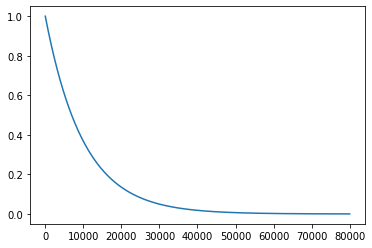

In [6]:
x = np.arange(80000)
y = [temp_function(k) for k in x]
plt.plot(x, y)

/tmp/ipykernel_7506/2332681695.py:9: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(energy_difference/T))


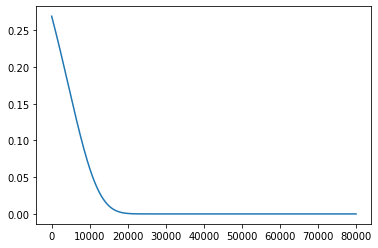

In [7]:
x = np.arange(80000)
y = [acceptance_function(temp_function(k), 1) for k in x]
plt.plot(x, y)

In [8]:
class SwapType(Enum):
    CONSECUTIVE = 1
    ARBITRARY = 2

def swap_permutation(permutation, swap_positions = None, swap_type = SwapType.CONSECUTIVE):
    N = len(permutation)
    # if positions is None we will generate them randomly
    if swap_positions == None:
        if swap_type == SwapType.CONSECUTIVE:
            temp = np.random.randint(0, N - 1, 1)
            swap_positions = np.array([temp, temp + 1])
            
        elif swap_type == SwapType.ARBITRARY:
            swap_positions = np.random.randint(0, N, 2)
            
        else:
            raise Exception("Wrong argument!")
    permutation[swap_positions[0]], permutation[swap_positions[1]] = permutation[swap_positions[1]], permutation[swap_positions[0]]
    
    return swap_positions[0], swap_positions[1]

In [9]:
# main function
def annealing(points, permutation, max_steps = 10000, costs = [], swap_type = SwapType.CONSECUTIVE):

    N: int = len(points)
    T: float = -1
    current_energy: float = cost_function(points, permutation)
    next_energy: float = -1
    best_energy: float = current_energy
    best_permutation = permutation
    for k in range(max_steps):
        T = temp_function(k)
        swap_positions: Tuple[int, int] = swap_permutation(permutation, swap_type = swap_type)
        next_energy = cost_function(points, permutation)

        # if new state not accepted swap back
        if not (acceptance_function(T, next_energy - current_energy) > np.random.uniform(0, 1)):
            swap_permutation(permutation, swap_positions, swap_type)
            # current energy stays the same
        else:
            current_energy = next_energy

        if best_energy > current_energy:
            best_energy = current_energy
            best_permutation = permutation

        if k % 100 == 0:
            costs.append(current_energy)
            
    permutation = best_permutation

In [10]:
class Dataset(Enum):
    UNIFORM = 1
    NORMAL = 2
    GROUPS = 3
    
def visualize_salesman(N = 10, dataset = Dataset.UNIFORM, normal_std = 1):
    # dataset
    points, permutation = None, None
    if dataset == Dataset.UNIFORM:
        points, permutation = generate_points(N)
    
    elif dataset == Dataset.NORMAL:
        permutation = np.arange(N)
        np.random.shuffle(permutation)
        points = np.random.normal(scale = normal_std, size = N * 2)
        points = np.reshape(points, (N, 2))
        
    
    elif dataset == Dataset.GROUPS:
        N_GROUP = N // 9
        points, _ = generate_points(N_GROUP)
        for i in range(3):
            for j in range(3):
                if i != 0 or j != 0:
                    temp_points, _ = generate_points(N_GROUP)
                    temp_points = temp_points + np.array([[2*i,2*j]])
                    points = np.append(points, temp_points, axis = 0)
        
        permutation = np.arange(len(points))
        np.random.shuffle(permutation)
    else:
        raise Exception("Wrong argument")
        
    visualize_path(points, permutation)
    print(cost_function(points, permutation))
    
    ### consecutive swaps
    # annealling
    costs = []
    annealing(points, permutation, 200000, costs, swap_type = SwapType.CONSECUTIVE)

    #plot costs
    x = np.arange(len(costs))
    y = costs
    plt.plot(x, y)
    plt.title("Consecutive swaps")
    plt.show()
    print(cost_function(points, permutation))

    #plot result
    visualize_path(points, permutation)
    
    ### Arbitrary swaps
    # annealling
    costs = []
    annealing(points, permutation, 200000, costs, swap_type = SwapType.ARBITRARY)

    #plot costs
    x = np.arange(len(costs))
    y = costs
    plt.plot(x, y)
    plt.title("Arbitrary swaps")
    plt.show()
    print(cost_function(points, permutation))

    #plot result
    visualize_path(points, permutation)


#### Uniform

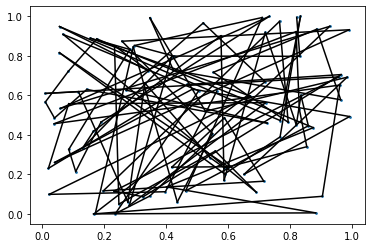

5.88047683704934


/tmp/ipykernel_7506/2332681695.py:9: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(energy_difference/T))


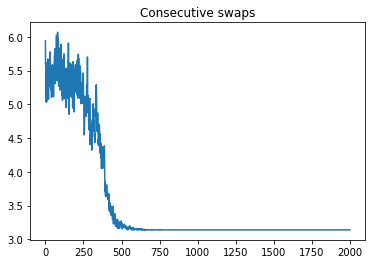

3.1401817485255723


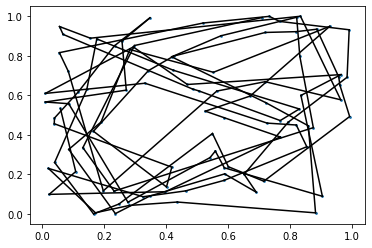

/tmp/ipykernel_7506/2332681695.py:9: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(energy_difference/T))


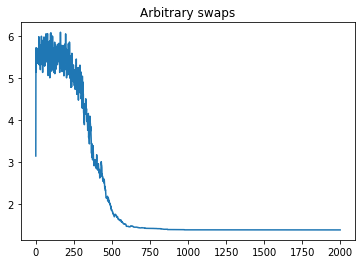

1.380581383489738


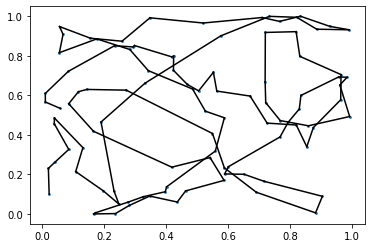

In [11]:
visualize_salesman(100, Dataset.UNIFORM)

#### Normal with std = 1

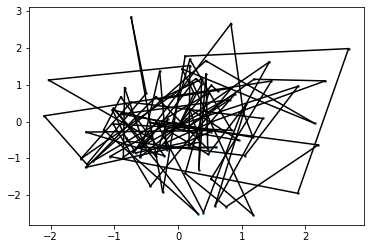

20.52097432639389


/tmp/ipykernel_7506/2332681695.py:9: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(energy_difference/T))


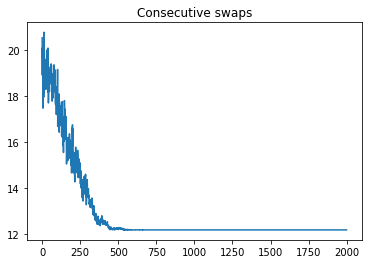

12.168226963916894


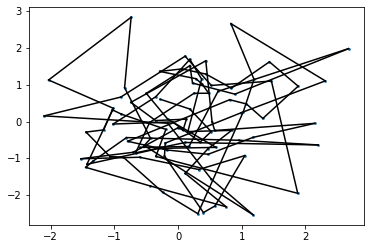

/tmp/ipykernel_7506/2332681695.py:9: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(energy_difference/T))


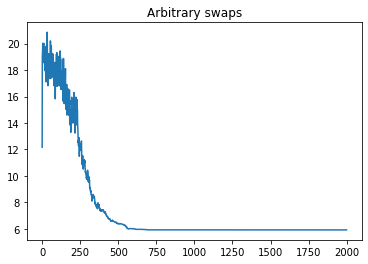

5.922981214780052


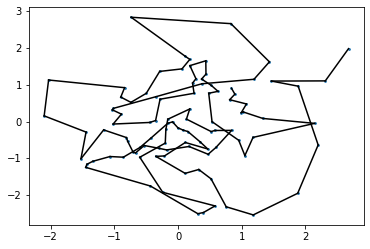

In [12]:
visualize_salesman(100, Dataset.NORMAL)

#### Normal with std = 3

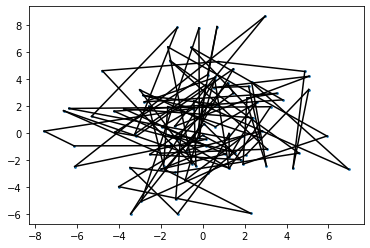

59.83111030130538


/tmp/ipykernel_7506/2332681695.py:9: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(energy_difference/T))


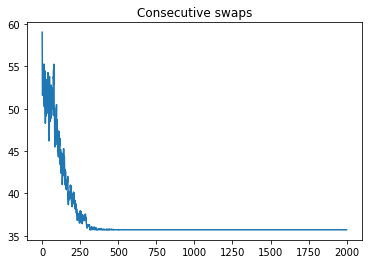

35.70156630645364


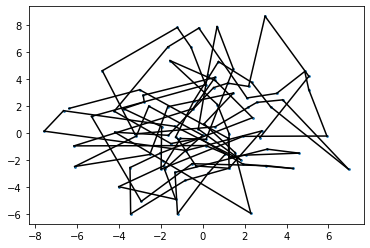

/tmp/ipykernel_7506/2332681695.py:9: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(energy_difference/T))


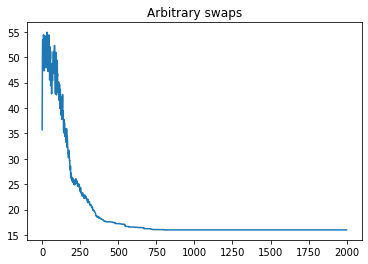

15.985491153656943


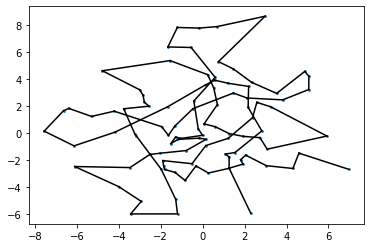

In [13]:
visualize_salesman(100, Dataset.NORMAL, normal_std=3)

#### Normal with std = 10

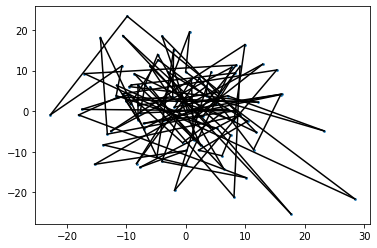

200.42187241226958


/tmp/ipykernel_7506/2332681695.py:9: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(energy_difference/T))


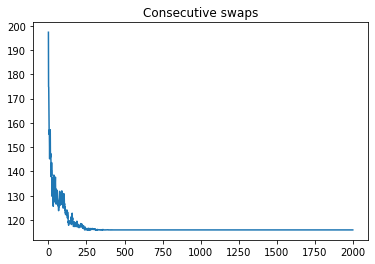

115.89430492661646


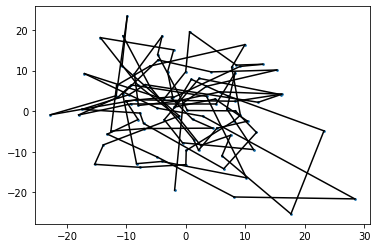

/tmp/ipykernel_7506/2332681695.py:9: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(energy_difference/T))


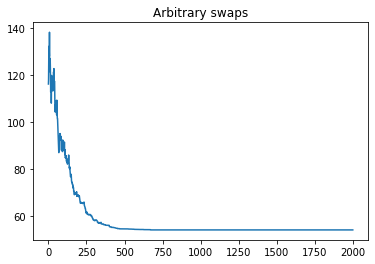

54.12433866034183


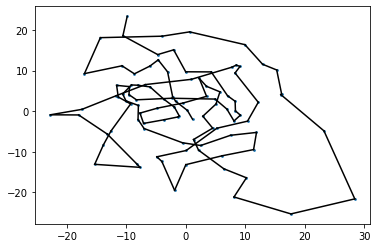

In [14]:
visualize_salesman(100, Dataset.NORMAL, normal_std=10)

#### Normal with std = 30

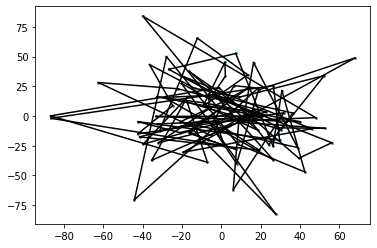

580.7072782593431


/tmp/ipykernel_7506/2332681695.py:9: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(energy_difference/T))


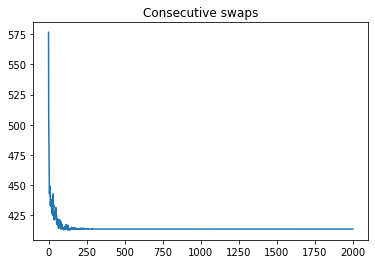

413.62578662293004


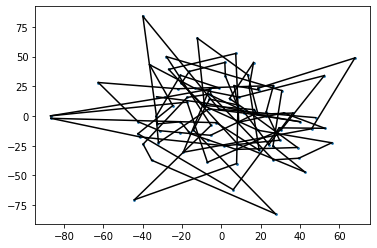

/tmp/ipykernel_7506/2332681695.py:9: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(energy_difference/T))


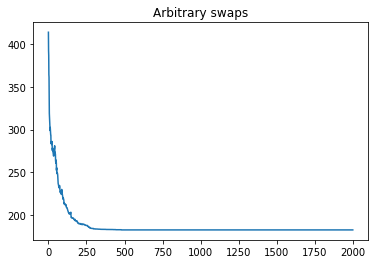

182.87541121216225


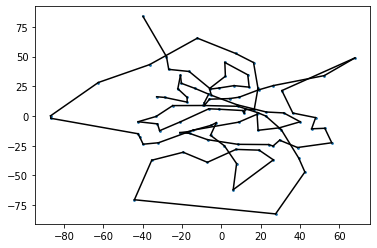

In [15]:
visualize_salesman(100, Dataset.NORMAL, normal_std=30)

#### Groups

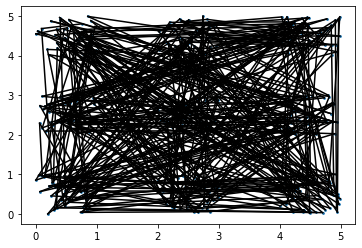

67.16185968412448


/tmp/ipykernel_7506/2332681695.py:9: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(energy_difference/T))


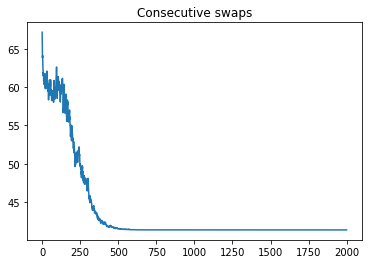

41.36748165947025


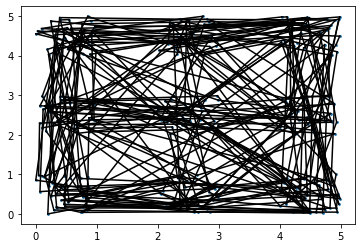

/tmp/ipykernel_7506/2332681695.py:9: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(energy_difference/T))


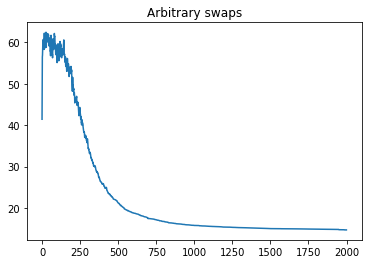

14.703438578877817


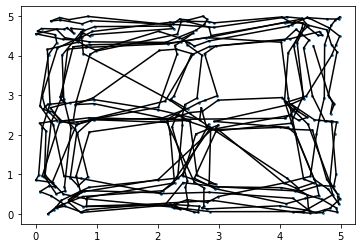

In [16]:
visualize_salesman(400, Dataset.GROUPS)

### Geometric temperature function

In [17]:
def temp_function(k):
    return 1 * 0.99995 ** k

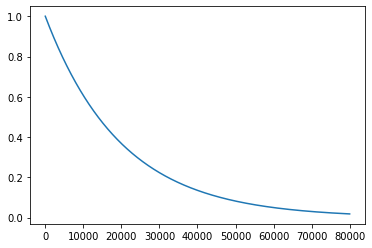

In [18]:
x = np.arange(80000)
y = [temp_function(k) for k in x]
plt.plot(x, y)

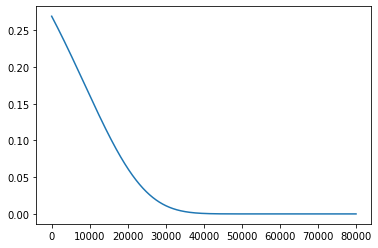

In [19]:
x = np.arange(80000)
y = [acceptance_function(temp_function(k), 1) for k in x]
plt.plot(x, y)

#### Uniform

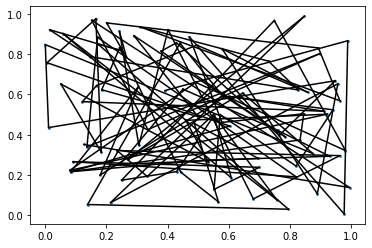

5.938705474001433


/tmp/ipykernel_7506/2332681695.py:9: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(energy_difference/T))


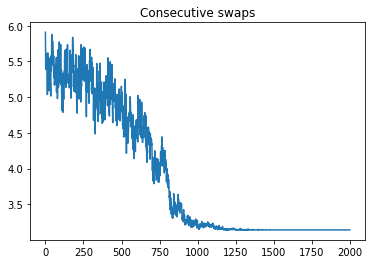

3.1406049553489965


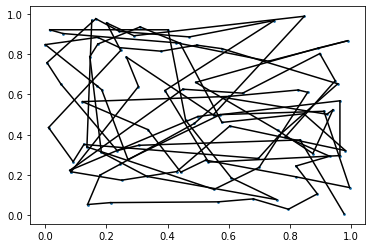

/tmp/ipykernel_7506/2332681695.py:9: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(energy_difference/T))


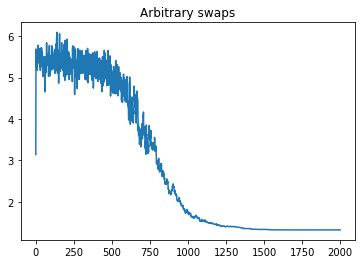

1.3194058292652502


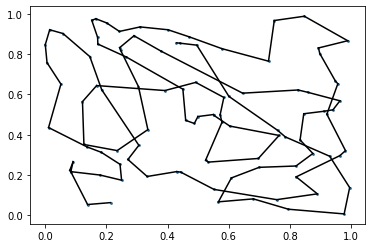

In [20]:
visualize_salesman(100, Dataset.UNIFORM)

#### Normal with std = 1

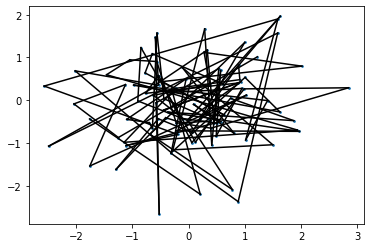

19.45149824723023


/tmp/ipykernel_7506/2332681695.py:9: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(energy_difference/T))


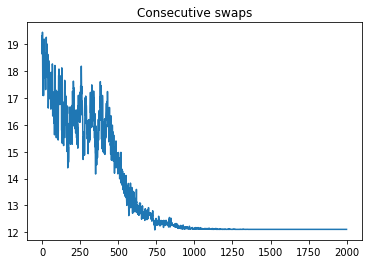

12.109033365710898


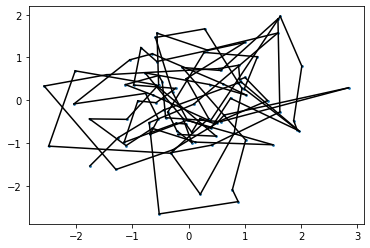

/tmp/ipykernel_7506/2332681695.py:9: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(energy_difference/T))


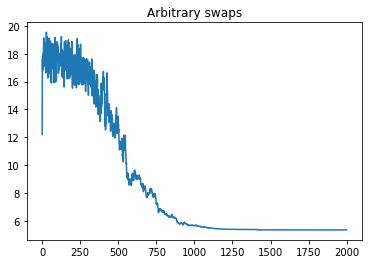

5.337880008800871


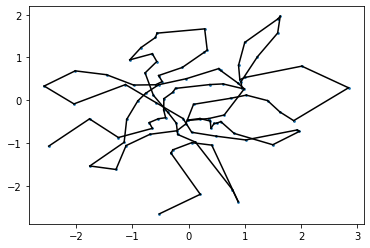

In [21]:
visualize_salesman(100, Dataset.NORMAL)

#### Normal with std = 3

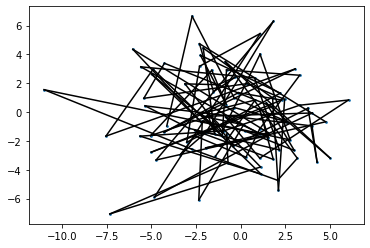

58.085336927114795


/tmp/ipykernel_7506/2332681695.py:9: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(energy_difference/T))


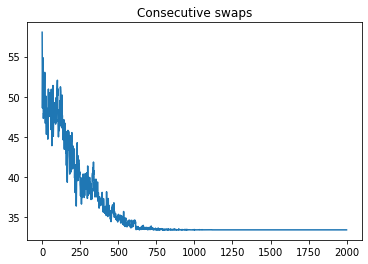

33.3823113436033


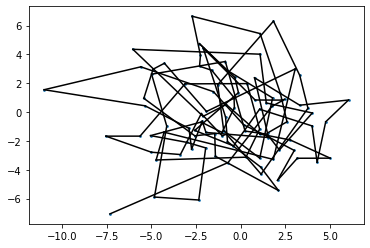

/tmp/ipykernel_7506/2332681695.py:9: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(energy_difference/T))


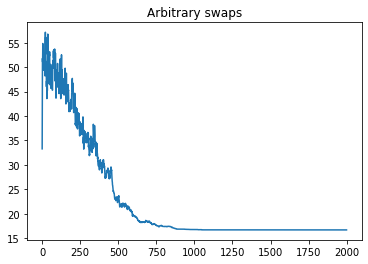

16.685776574011292


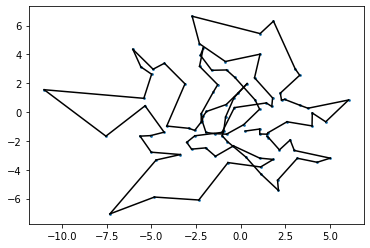

In [22]:
visualize_salesman(100, Dataset.NORMAL, normal_std=3)

#### Normal with std = 10

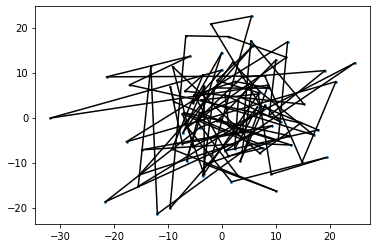

193.90529320671078


/tmp/ipykernel_7506/2332681695.py:9: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(energy_difference/T))


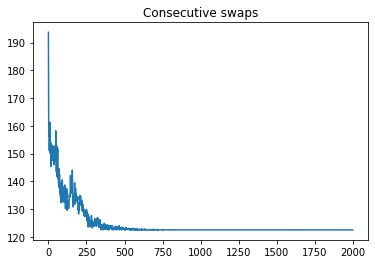

122.48274367201495


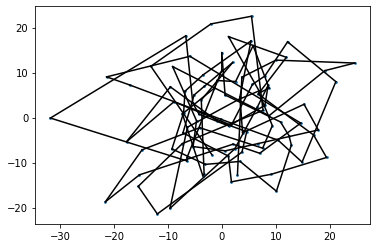

/tmp/ipykernel_7506/2332681695.py:9: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(energy_difference/T))


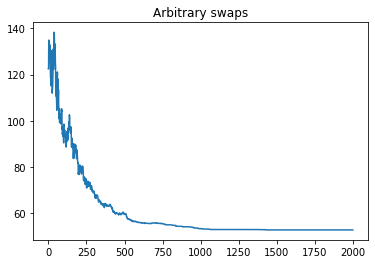

52.80324236503834


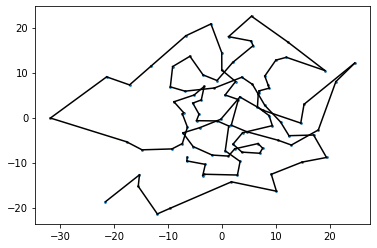

In [23]:
visualize_salesman(100, Dataset.NORMAL, normal_std=10)

#### Normal with std = 30

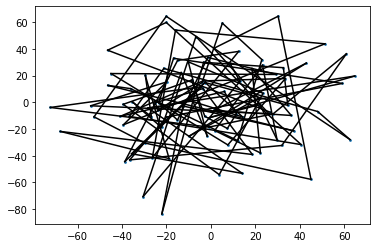

611.6996866698889


/tmp/ipykernel_7506/2332681695.py:9: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(energy_difference/T))


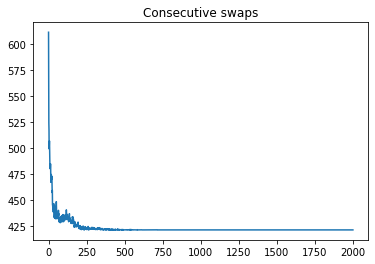

421.6595385917241


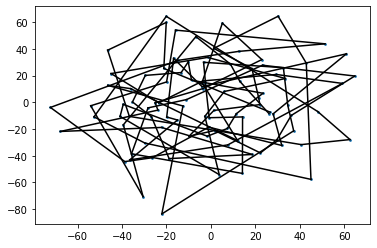

/tmp/ipykernel_7506/2332681695.py:9: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(energy_difference/T))


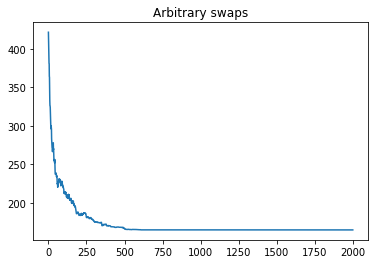

164.74383906476874


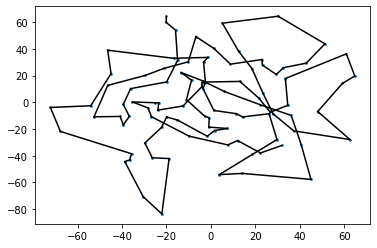

In [24]:
visualize_salesman(100, Dataset.NORMAL, normal_std=30)

#### Groups

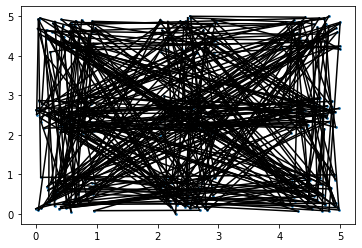

65.40558326276985


/tmp/ipykernel_7506/2332681695.py:9: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(energy_difference/T))


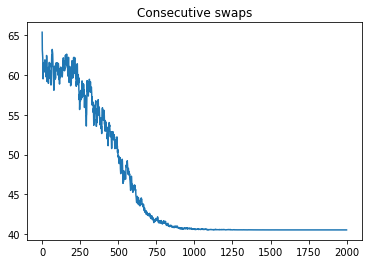

40.53445216838359


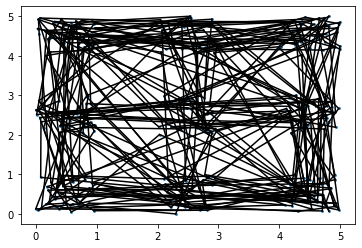

/tmp/ipykernel_7506/2332681695.py:9: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(energy_difference/T))


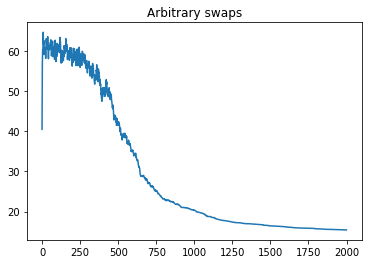

15.40451072931743


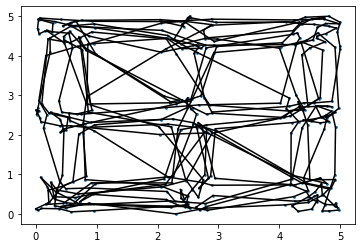

In [25]:
visualize_salesman(400, Dataset.GROUPS)

### Wnioski:
Arbitrary swap sprawuje się dużo lepiej niż consecutive swap. Spowodowane jest to prawdopodobnie tym ,ze podczas arbitralnych zmian moze dojść do większej liczby początkowo niekorzystych zmian które jednak okazały się kluczowe do optymalizacji zadania.

Porównałem także dwie funkcje temperatury - wykładniczą i geometryczną, nie zaobserwowałem jednak znaczących różnic w zbieżności.

### Animation of the process

In [47]:
def annealing_anim(points, permutation, max_steps = 10000):

    N: int = len(points)
    T: float = -1
    current_energy: float = cost_function(points, permutation)
    next_energy: float = -1
    best_energy: float = current_energy
    best_permutation = permutation
    for k in range(max_steps):
        T = temp_function(k)
        swap_positions: Tuple[int, int] = swap_permutation(permutation, swap_type = SwapType.ARBITRARY)
        next_energy = cost_function(points, permutation)

        # if new state not accepted swap back
        if not (acceptance_function(T, next_energy - current_energy) > np.random.uniform(0, 1)):
            swap_permutation(permutation, swap_positions, SwapType.ARBITRARY)
            # current energy stays the same
        else:
            current_energy = next_energy

        if best_energy > current_energy:
            best_energy = current_energy
            best_permutation = permutation

        if k % 100 == 0:
            n = points.shape[0]
            permuted = points[permutation]
            plt.scatter(permuted[:, 0], permuted[:, 1], s = 3) 

            for i in range(n-1):
                plt.plot([permuted[i][0], permuted[i+1][0]], [permuted[i][1], permuted[i+1][1]], color='black')
            
            plt.savefig(f'data/anim_frames1/{str(k//100).zfill(3)}')
            print(k)
    permutation = best_permutation

In [ ]:
N = 100
points, permutation = generate_points(N)
max_steps = 20000
annealing_anim(points, permutation, max_steps)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

In [ ]:
file_names = sorted((fn for fn in os.listdir('data/anim_frames1')), reverse = True)
#making animation
with io.get_writer('data/anim1.gif', mode='I', duration=0.0001) as writer:
    for filename in file_names:
        image = io.imread(f'data/anim_frames1/{filename}')
        writer.append_data(image)
writer.close()

![Alt Text](data/anim1.gif)